In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Importing the data

In [2]:
raw_data = pd.read_csv('Index2018.csv')
raw_data.head()
# market indexes

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Transform raw data into Time-Series Data

In [3]:
df = raw_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index('date', inplace = True)
df = df.asfreq('b') # 'b' - business days
df.fillna(method = 'ffill', inplace = True)
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [4]:
df.isna().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

## Using Returns

In [5]:
# create returns out of prices
# returns = (p(t) - p(t-1)) / p(t-1)
df['ftse_returns'] = df.ftse.pct_change(1).mul(100)
df.head()

,spx,dax,ftse,nikkei,ftse_returns
date,,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01,NaN
1994-01-10,475.27,2225.00,3440.58,18443.44,-0.156704
1994-01-11,474.13,2228.10,3413.77,18485.25,-0.779229
1994-01-12,474.17,2182.06,3372.02,18793.88,-1.222988
1994-01-13,472.47,2142.37,3360.01,18577.26,-0.356166


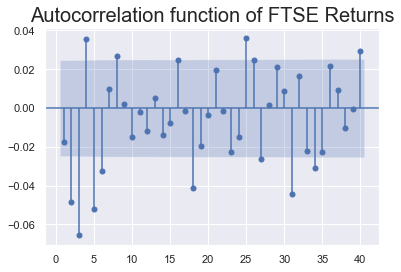

In [6]:
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(df.ftse_returns.iloc[1:], lags = 40, zero = False)
plt.title('Autocorrelation function of FTSE Returns', size = 20)
plt.show()

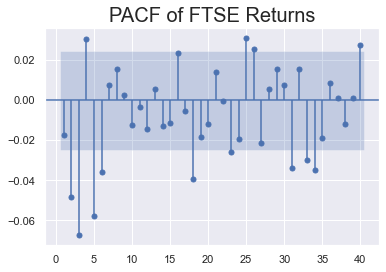

In [7]:
sgt.plot_pacf(df.ftse_returns.iloc[1:], lags = 40, zero = False, alpha = 0.05, method = ('ols'))
plt.title('PACF of FTSE Returns', size = 20)
plt.show()

## Log Likelihood Ratio (LLR) Test

In [8]:
from scipy.stats.distributions import chi2

def LLR_test(model_1, model_2, DF = 1):
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    
    LR = 2*(L2 - L1)
    p = chi2.sf(LR, DF).round(3)
    
    return p

## ARMA(1, 1) model

In [9]:
from statsmodels.tsa.arima.model import ARIMA

arma_1 = ARIMA(df.ftse_returns.iloc[1:], order = (1, 0, 1))
results_arma_1 = arma_1.fit()
results_arma_1.summary()

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ftse_returns   No. Observations:                 6276
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -9582.339
Date:                Thu, 17 Nov 2022   AIC                          19172.679
Time:                        00:53:51   BIC                          19199.657
Sample:                    01-10-1994   HQIC                         19182.026
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.012      1.548      0.122      -0.005       0.043
ar.L1          0.8178      0.033     24.484      0.000       0.752       0.883
ma.L1         -0.8594      0.030    -28.964      0.000      -0.918      -0.801
sigma2         1.2408      0.011    111.349      0.000       1.219       1.263
===================================================================================
Ljung-Box (L1) (Q):                   2.19   Jarque-Bera (JB):             10103.13
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# is ARMA model better predictor then AR(1) and MA(1) models?

ar_1 = ARIMA(df.ftse_returns.iloc[1:], order = (1, 0, 0))
ar_1.fit()

LLR_test(ar_1, arma_1, DF = 1) # ARMA - 2 DF, AR - 1 DF, 2-1=1

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.0

In [11]:
ma_1 = ARIMA(df.ftse_returns.iloc[1:], order = (0, 0, 1))
ma_1.fit()

LLR_test(ma_1, arma_1, DF = 1)

0.0

## Higher-Lag ARMA Models

In [12]:
# start with overfitted model
# take No of lags based on previously fitted AR and MA models
arma_8_6 = ARIMA(df.ftse_returns.iloc[1:], order = (8, 0, 6))
results_arma_8_6 = arma_8_6.fit()
results_arma_8_6.summary()

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ftse_returns   No. Observations:                 6276
Model:                 ARIMA(8, 0, 6)   Log Likelihood               -9552.330
Date:                Thu, 17 Nov 2022   AIC                          19136.661
Time:                        01:06:32   BIC                          19244.572
Sample:                    01-10-1994   HQIC                         19174.050
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.012      1.598      0.110      -0.004       0.042
ar.L1         -0.1739      0.357     -0.487      0.626      -0.874       0.526
ar.L2         -0.0374      0.181     -0.207      0.836      -0.392       0.317
ar.L3          0.0074      0.111      0.066      0.947      -0.210       0.225
ar.L4          0.4886      0.111      4.410      0.000       0.271       0.706
ar.L5          0.4922      0.224      2.198      0.028       0.053       0.931
ar.L6         -0.1509      0.173     -0.870      0.384      -0.491       0.189
ar.L7          0.0498      0.015      3.221      0.001       0.019       0.080
ar.L8          0.0291      0.024      1.226      0.220      -0.017       0.076
ma.L1          0.1532      0.356      0.431      0.667      -0.544       0.851
ma.L2         -0.0145      0.176     -0.082      0.934      -0.360       0.331
ma.L3         -0.0854      0.105     -0.814      0.415      -0.291       0.120
ma.L4         -0.4770      0.092     -5.203      0.000      -0.657      -0.297
ma.L5         -0.5233      0.222     -2.360      0.018      -0.958      -0.089
ma.L6          0.1584      0.183      0.864      0.388      -0.201       0.518
sigma2         1.2285      0.012    101.115      0.000       1.205       1.252
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8851.96
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# p-values of coefficients look bad
# lets try the "half" of previous model - ARMA(4,3)
arma_4_3 = ARIMA(df.ftse_returns.iloc[1:], order = (4, 0, 3))
results_arma_4_3 = arma_4_3.fit()
results_arma_4_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ftse_returns   No. Observations:                 6276
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -9562.327
Date:                Thu, 17 Nov 2022   AIC                          19142.654
Time:                        01:08:59   BIC                          19203.355
Sample:                    01-10-1994   HQIC                         19163.686
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.012      1.586      0.113      -0.004       0.043
ar.L1          0.1495      0.093      1.611      0.107      -0.032       0.331
ar.L2          0.2045      0.073      2.790      0.005       0.061       0.348
ar.L3          0.3458      0.074      4.686      0.000       0.201       0.491
ar.L4          0.0667      0.011      6.058      0.000       0.045       0.088
ma.L1         -0.1696      0.094     -1.806      0.071      -0.354       0.014
ma.L2         -0.2544      0.073     -3.467      0.001      -0.398      -0.111
ma.L3         -0.4041      0.076     -5.297      0.000      -0.554      -0.255
sigma2         1.2329      0.012    104.797      0.000       1.210       1.256
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9031.37
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
LLR_test(arma_1, arma_4_3, DF = 5)

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0.0

In [17]:
arma_3_2 = ARIMA(df.ftse_returns.iloc[1:], order = (3, 0, 2))
results_arma_3_2 = arma_3_2.fit()
LLR_test(arma_3_2, arma_4_3, DF = 2), results_arma_3_2.summary()

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0.001,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:           ftse_returns   No. Observations:                 6276
 Model:                 ARIMA(3, 0, 2)   Log Likelihood               -9568.878
 Date:                Thu, 17 Nov 2022   AIC                          19151.755
 Time:                        01:17:37   BIC                          19198.967
 Sample:                    01-10-1994   HQIC                         19168.113
                          - 01-29-2018                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.0190      0.013      1.419      0.156      -0.007       0.045
 ar.L1         -0.6807      0.066    -10.268      0.000      -

In [19]:
arma_2_3 = ARIMA(df.ftse_returns.iloc[1:], order = (2, 0, 3))
results_arma_2_3 = arma_2_3.fit()
LLR_test(arma_2_3, arma_4_3, DF = 2), results_arma_2_3.summary()

(0.004,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:           ftse_returns   No. Observations:                 6276
 Model:                 ARIMA(2, 0, 3)   Log Likelihood               -9567.739
 Date:                Thu, 17 Nov 2022   AIC                          19149.478
 Time:                        01:18:55   BIC                          19196.689
 Sample:                    01-10-1994   HQIC                         19165.835
                          - 01-29-2018                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.0190      0.013      1.448      0.148      -0.007       0.045
 ar.L1         -0.5359      0.070     -7.686      0.000      -

In [20]:
arma_3_3 = ARIMA(df.ftse_returns.iloc[1:], order = (3, 0, 3))
results_arma_3_3 = arma_3_3.fit()
LLR_test(arma_3_3, arma_4_3), results_arma_3_3.summary()

(0.025,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:           ftse_returns   No. Observations:                 6276
 Model:                 ARIMA(3, 0, 3)   Log Likelihood               -9564.829
 Date:                Thu, 17 Nov 2022   AIC                          19145.657
 Time:                        01:27:08   BIC                          19199.613
 Sample:                    01-10-1994   HQIC                         19164.352
                          - 01-29-2018                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.0190      0.013      1.516      0.130      -0.006       0.044
 ar.L1         -0.1261      0.070     -1.809      0.070      -

In [21]:
# arma_4_3 model looks the best of explored

## Explore Residuals

In [22]:
df['ftse_returns_residuals'] = results_arma_4_3.resid[1:]

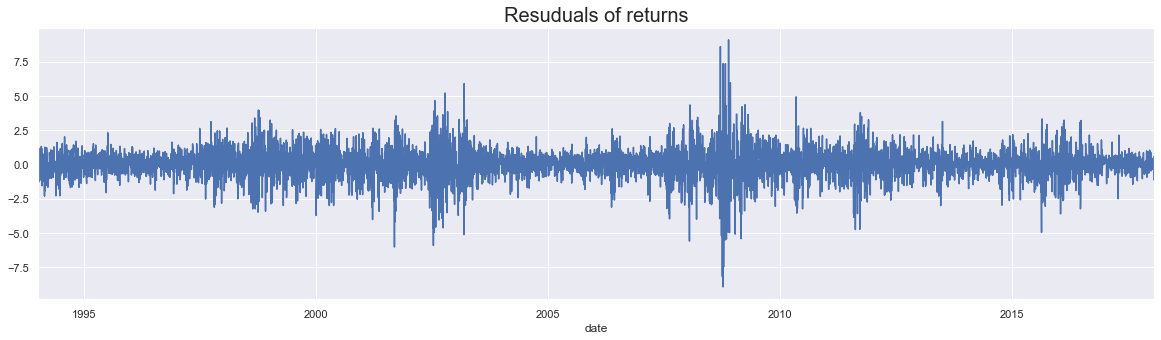

In [23]:
df.ftse_returns_residuals.plot(figsize = (20, 5))
plt.title('Resuduals of returns', size = 20)
plt.show()

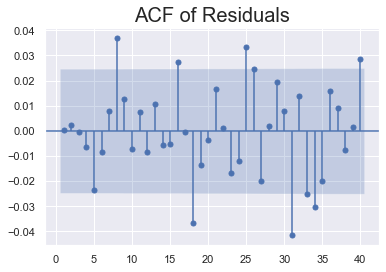

In [25]:
# to make sure that residuals are random we should plot ACF
sgt.plot_acf(df.ftse_returns_residuals.iloc[2:], lags = 40, zero = False)
plt.title('ACF of Residuals', size = 20)
plt.show()

## Reevaluating Model Selection

In [26]:
arma_5_5 = ARIMA(df.ftse_returns.iloc[1:], order = (5, 0, 5))
results_arma_5_5 = arma_5_5.fit()
results_arma_5_5.summary()

C:\Users\0x17h\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ftse_returns   No. Observations:                 6276
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -9554.286
Date:                Thu, 17 Nov 2022   AIC                          19132.573
Time:                        01:36:39   BIC                          19213.507
Sample:                    01-10-1994   HQIC                         19160.615
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.012      1.536      0.125      -0.005       0.043
ar.L1         -0.1967      0.109     -1.802      0.072      -0.411       0.017
ar.L2         -0.4353      0.070     -6.260      0.000      -0.572      -0.299
ar.L3         -0.0344      0.064     -0.539      0.590      -0.159       0.091
ar.L4          0.3268      0.062      5.236      0.000       0.204       0.449
ar.L5          0.3137      0.082      3.819      0.000       0.153       0.475
ma.L1          0.1737      0.108      1.607      0.108      -0.038       0.385
ma.L2          0.3844      0.069      5.588      0.000       0.250       0.519
ma.L3         -0.0448      0.061     -0.733      0.463      -0.165       0.075
ma.L4         -0.3221      0.060     -5.369      0.000      -0.440      -0.205
ma.L5         -0.3827      0.078     -4.889      0.000      -0.536      -0.229
sigma2         1.2302      0.012    102.430      0.000       1.207       1.254
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              8759.35
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
arma_1_5 = ARIMA(df.ftse_returns.iloc[1:], order = (1, 0, 5))
results_arma_1_5 = arma_1_5.fit()
results_arma_1_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ftse_returns   No. Observations:                 6276
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -9561.034
Date:                Thu, 17 Nov 2022   AIC                          19138.068
Time:                        01:58:29   BIC                          19192.024
Sample:                    01-10-1994   HQIC                         19156.762
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.012      1.525      0.127      -0.005       0.043
ar.L1          0.3013      0.120      2.503      0.012       0.065       0.537
ma.L1         -0.3215      0.121     -2.661      0.008      -0.558      -0.085
ma.L2         -0.0425      0.008     -5.104      0.000      -0.059      -0.026
ma.L3         -0.0547      0.010     -5.576      0.000      -0.074      -0.035
ma.L4          0.0525      0.012      4.469      0.000       0.029       0.076
ma.L5         -0.0625      0.008     -8.259      0.000      -0.077      -0.048
sigma2         1.2324      0.012    104.569      0.000       1.209       1.256
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8897.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
arma_5_1 = ARIMA(df.ftse_returns.iloc[1:], order = (5, 0, 1))
results_arma_5_1 = arma_5_1.fit()
results_arma_5_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ftse_returns   No. Observations:                 6276
Model:                 ARIMA(5, 0, 1)   Log Likelihood               -9559.969
Date:                Thu, 17 Nov 2022   AIC                          19135.937
Time:                        01:58:37   BIC                          19189.893
Sample:                    01-10-1994   HQIC                         19154.632
                         - 01-29-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.012      1.523      0.128      -0.005       0.043
ar.L1          0.3205      0.102      3.153      0.002       0.121       0.520
ar.L2         -0.0456      0.008     -5.614      0.000      -0.062      -0.030
ar.L3         -0.0535      0.009     -5.934      0.000      -0.071      -0.036
ar.L4          0.0520      0.010      5.057      0.000       0.032       0.072
ar.L5         -0.0709      0.007     -9.713      0.000      -0.085      -0.057
ma.L1         -0.3398      0.103     -3.315      0.001      -0.541      -0.139
sigma2         1.2320      0.012    105.049      0.000       1.209       1.255
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8874.95
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
print('ARMA(4, 3) \tLL: {}, \tAIC: {}'.format(results_arma_4_3.llf, results_arma_4_3.aic))
print('ARMA(5, 1) \tLL: {}, \tAIC: {}'.format(results_arma_5_1.llf, results_arma_5_1.aic))
print('ARMA(1, 5) \tLL: {}, \tAIC: {}'.format(results_arma_1_5.llf, results_arma_1_5.aic))

ARMA(4, 3) 	LL: -9562.327153917377, 	AIC: 19142.654307834753
ARMA(5, 1) 	LL: -9559.968657698355, 	AIC: 19135.93731539671
ARMA(1, 5) 	LL: -9561.033836573235, 	AIC: 19138.06767314647


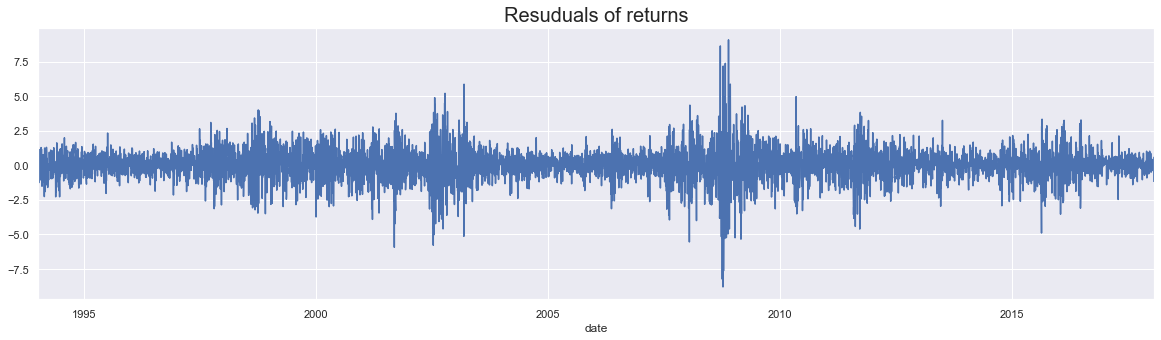

In [37]:
# arma(5,1) is better then ARMA(4,3)
# lets explore residuals

results_arma_5_1.resid.plot(figsize = (20, 5))
plt.title('Resuduals of returns', size = 20)
plt.show()

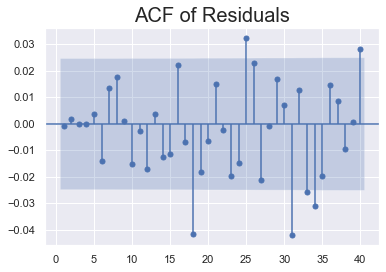

In [38]:
# to make sure that residuals are random we should plot ACF
sgt.plot_acf(results_arma_5_1.resid.iloc[2:], lags = 40, zero = False)
plt.title('ACF of Residuals', size = 20)
plt.show()